In [51]:
import numpy as np
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import fits
import glob
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn import pipeline
from sklearn.base import BaseEstimator, TransformerMixin

## Grab and Preprocess Coadded fluxes

In [52]:
# Grab coadded file names
files_host = np.sort(glob.glob('/scratch/sbenzvi_lab/desi/time-domain/bgs/hosts/*/*coadd.fits'))
files_ia = np.sort(glob.glob('/scratch/sbenzvi_lab/desi/time-domain/bgs/sne_ia/*/*coadd.fits'))
files_iip = np.sort(glob.glob('/scratch/sbenzvi_lab/desi/time-domain/bgs/sne_iip/*/*coadd.fits'))

# remove 002 from iip, targetIDs don't match
files_iip = np.delete(files_iip, 2)

In [53]:
# function for grabbing list of coadded flux spectra from list of files
def grabFluxFromFiles(list_of_files):
    target_id = []
    flux = []
    for f in list_of_files:
        h = fits.open(f)
        fl = h[1].data
        flux.append(fl)
        t1 = h['FIBERMAP'].data['TARGETID']
        target_id.append(t1)
    return np.concatenate(flux), np.asarray(target_id)

In [54]:
# filter out the nonzero fluxes, returns a binary list of where nonzeros are located in original list and the filtered
# list itself
def grabNonZeros(fluxes):
    nonzero_spectra_binary = np.count_nonzero(fluxes, axis=1)!=0
    fluxes_nonzero = fluxes[nonzero_spectra_binary]
    return nonzero_spectra_binary, fluxes_nonzero

In [55]:
# function for decimating fluxes to 400 features
def Decimator(fluxes):
    return np.median(fluxes[:,:6000].reshape(-1,400,15),2)

In [154]:
# Min-Max Normalizer
def minMaxNormalizeAcrossFeatures(decimated):
    maxflux = decimated.max(axis=0)#.reshape(-1,1)
    minflux = decimated.min(axis=0)#.reshape(-1,1)
    standardized = (decimated - minflux)/(maxflux-minflux)
    return standardized

In [155]:
# Min-Max Normalizer
def minMaxNormalize(decimated):
    maxflux = decimated.max(axis=-1).reshape(-1,1)
    minflux = decimated.min(axis=-1).reshape(-1,1)
    standardized = (decimated - minflux)/(maxflux-minflux)
    return standardized

In [56]:
# Get fluxes
fluxes_host, target_id_host = grabFluxFromFiles(files_host)
fluxes_ia, target_id_ia = grabFluxFromFiles(files_ia)
fluxes_iip, target_id_iip = grabFluxFromFiles(files_iip)

In [57]:
# Filter nonzero fluxes
nonzero_hosts_binary, fluxes_host = grabNonZeros(fluxes_host)
nonzero_ia_binary, fluxes_ia = grabNonZeros(fluxes_ia)
nonzero_iip_binary, fluxes_iip = grabNonZeros(fluxes_iip)

In [58]:
# Decimate fluxes
decimated_fluxes_host = Decimator(fluxes_host)
decimated_fluxes_ia = Decimator(fluxes_ia)
decimated_fluxes_iip = Decimator(fluxes_iip)

In [156]:
# Normalized fluxes

standardized_hosts = minMaxNormalize(decimated_fluxes_host)
standardized_ia = minMaxNormalize(decimated_fluxes_ia)
standardized_iip = minMaxNormalize(decimated_fluxes_iip)

#standardized = minMaxNormalizeAcrossFeatures(np.concatenate([decimated_fluxes_host, decimated_fluxes_ia, decimated_fluxes_iip]))

[[ 19.5125302    1.18203787  -5.16623421 ...   5.1361331    4.13738704
    4.28294089]
 [  0.62361153  -9.62853587   1.93345506 ...   3.44343176   2.72153166
    2.19060456]
 [ 27.84650477 -11.6529527   -3.24463762 ...   3.24923349   1.02366292
    1.12124701]
 ...
 [ 11.71586167  39.64405138  23.50698867 ...  27.89071028  29.91313831
   28.12389265]
 [-14.33003244   6.57013011   1.55832046 ...   2.83613465   2.80721929
    3.32901301]
 [ 12.89414193  14.01547982  -4.27121369 ...   1.12295669   2.38146914
    3.02301301]]
[[0.96889774 0.40158178 0.20510718 ... 0.52395827 0.49304777 0.49755256]
 [0.60939202 0.         0.68724968 ... 0.77700334 0.73409329 0.70253476]
 [1.         0.         0.21287166 ... 0.37727572 0.32093139 0.3234019 ]
 ...
 [0.12122504 0.69290325 0.36258442 ... 0.45231734 0.49371558 0.45709048]
 [0.         0.82319365 0.62579376 ... 0.67612296 0.67498407 0.69553594]
 [0.95572248 1.         0.27792549 ... 0.49092151 0.54061555 0.56594777]]
(99588, 6265)
(99588, 1)


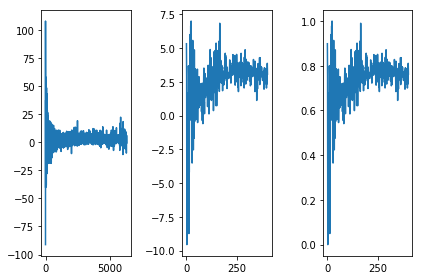

In [178]:
print(decimated_fluxes_host)
print(standardized_hosts)
print(fluxes_host.shape)
print(fluxes_host.max(axis=-1).reshape(-1,1).shape)
plt.subplot(131)
plt.plot(fluxes_host[8])
plt.subplot(132)
plt.plot(decimated_fluxes_host[8])
plt.subplot(133)
plt.plot(standardized_hosts[8])
plt.tight_layout()

## Grab and Preprocess Truth Files

In [186]:
# These match with the files we've chosen before, so the target IDs should match when we get truth data
info_files_hosts = ['/'.join(f.split('/')[:-1]) + '/{}truth.fits'.format(f.split('/')[-1][:-10]) for f in files_host]
info_files_ia = ['/'.join(f.split('/')[:-1]) + '/{}truth.fits'.format(f.split('/')[-1][:-10]) for f in files_ia]
info_files_iip = ['/'.join(f.split('/')[:-1])+ '/{}truth.fits'.format(f.split('/')[-1][:-10]) for f in files_iip]

In [187]:
# Function to return corresponding truez and flux magnitudes of host spectra
# Exception raised if targetIDs don't match
def getHostTruths(info_files, target_id_list, nonzero_hosts):
    from functools import reduce
    truez_ = []
    rmags_ = []
    #flux_ = []
    i = 0
    for f in info_files:
        h = fits.open(f)
        
        # Check if target ids match first, if not, then stop and throw error.
        lis = (h['TRUTH'].data['TARGETID']==target_id_list[i])
        target_id_match = reduce((lambda a,b: a&b), lis)
        if not target_id_match:
            raise Exception("The Target IDs in our process did not match: {}, index: {}".format(info_files[i], i))
        
        #else we collect flux_r and truez
        z = h[3].data['TRUEZ']
        truez_.append(z)
        m = 22.5 - 2.5*np.log10(h[3].data['FLUX_R'])
        rmags_.append(m)
        
        #fl = h['FLUX'].data
        #flux_.append(fl)
        
        i = i+1

    # filter using nonzero binary we had from coadded files
    truez_hosts = np.concatenate(truez_)[nonzero_hosts]
    rmags_hosts = np.concatenate(rmags_)[nonzero_hosts]
    #noiseless_fluxes_hosts  = np.concatenate(flux_)[nonzero_hosts]
    return truez_hosts, rmags_hosts #, noiseless_fluxes_hosts

In [188]:
# Function to return corresponding truez, flux ratios, epochs, and flux magnitudes of transient spectra
# Exception raised if targetIDs don't match
def getTransientTruths(info_files, target_id_list, nonzero_bin):
    from functools import reduce
    rfr_ = []
    truez_ = []
    rmags_ = []
    epochs_ = []
    
    missing_targets = []
    i = 0
    for f in info_files:
        h = fits.open(f)
        
        # Check if target ids match first, if not, then stop and throw error.
        lis = (h['TRUTH'].data['TARGETID']==target_id_list[i])
        target_id_match = reduce((lambda a,b: a&b), lis)
        if not target_id_match:
            raise Exception("The Target IDs in our process did not match: {} index: {}".format(i, info_files[i]))
            '''missing_targets.append((i, target_id_list[i], h['TRUTH'].data['TARGETID']))
            r = h[3].data['SNE_FLUXRATIO']
            rfr_.append(r)
            z = h[3].data['TRUEZ']
            truez_.append(z)
            m = 22.5 - 2.5*np.log10(h[3].data['FLUX_R'])
            rmags_.append(m)
            e = h[3].data['SNE_EPOCH']
            epochs_.append(e)
            i = i+1
            continue'''
        
        #else we collect flux ratios, truez, flux_r, and epoch
        r = h[3].data['SNE_FLUXRATIO']
        rfr_.append(r)
        z = h[3].data['TRUEZ']
        truez_.append(z)
        m = 22.5 - 2.5*np.log10(h[3].data['FLUX_R'])
        rmags_.append(m)
        e = h[3].data['SNE_EPOCH']
        epochs_.append(e)
        
        i = i+1

    # filter using nonzero binary we had from coadded files
    rfr = np.concatenate(rfr_)[nonzero_bin]
    truez = np.concatenate(truez_)[nonzero_bin]
    rmags = np.concatenate(rmags_)[nonzero_bin]
    epochs = np.concatenate(epochs_).astype(int)[nonzero_bin]
        
    return rfr, truez, rmags, epochs

In [189]:
# Get Host Truth Data
truez_hosts, rmags_hosts = getHostTruths(info_files_hosts, target_id_host, nonzero_hosts_binary)

In [190]:
# Get IA Truth Data
rfr_ia, truez_ia, rmags_ia, epochs_ia = getTransientTruths(info_files_ia, target_id_ia, nonzero_ia_binary)

In [191]:
# Get IIP Truth Data
rfr_iip, truez_iip, rmags_iip, epochs_iip = getTransientTruths(info_files_iip, target_id_iip, nonzero_iip_binary)

In [192]:
# Nan Cleanup function for rfr, just converts them to 0
def nanCleanUp(arr):
    return np.array([a if ~np.isnan(a) else 0 for a in arr])

In [193]:
# Clean up Nans
rfr_ia_clean = nanCleanUp(rfr_ia)
rfr_iip_clean = nanCleanUp(rfr_iip)

In [194]:
print(len(standardized_hosts), len(np.concatenate(target_id_host)[nonzero_hosts_binary]), len(files_host))
print(len(standardized_ia), len(np.concatenate(target_id_ia)[nonzero_ia_binary]),  len(files_ia))
print(len(standardized_iip), len(np.concatenate(target_id_iip)[nonzero_iip_binary]),  len(files_iip))

99588 99588 1000
99492 99492 1000
120155 120155 1206


## Save all data into Fits files

In [196]:
hduL = fits.HDUList()

hdr = fits.Header()
hdr['DESC'] = "Nonzero Standardized Host Spectra"
hdu = fits.PrimaryHDU(header=hdr)
hdu.data = standardized_hosts
hduL.append(hdu)

hdr = fits.Header()
hdr['DESC'] = "Nonzero Standardized Host TargetIDs"
hdu = fits.PrimaryHDU(header=hdr)
hdu.data = np.concatenate(target_id_host)[nonzero_hosts_binary]
hduL.append(hdu)

hdr = fits.Header()
hdr['DESC'] = "Nonzero Standardized Host Flux Magnitudes"
hdu = fits.PrimaryHDU(header=hdr)
hdu.data = rmags_hosts
hduL.append(hdu)

hdr = fits.Header()
hdr['DESC'] = "Nonzero Standardized Host TrueZ"
hdu = fits.PrimaryHDU(header=hdr)
hdu.data = truez_hosts
hduL.append(hdu)

hduL.writeto('/scratch/dgandhi/desi/time-domain-bkup/cnn-data/hosts_data.fits', overwrite=True)

In [197]:
hduL = fits.HDUList()

hdr = fits.Header()
hdr['DESC'] = "Nonzero Standardized IA Spectra"
hdu = fits.PrimaryHDU(header=hdr)
hdu.data = standardized_ia
hduL.append(hdu)

hdr = fits.Header()
hdr['DESC'] = "Nonzero Standardized IA TargetIDs"
hdu = fits.PrimaryHDU(header=hdr)
hdu.data = np.concatenate(target_id_ia)[nonzero_ia_binary]
hduL.append(hdu)

hdr = fits.Header()
hdr['DESC'] = "Nonzero Standardized IA SNE-to-Host Flux Ratios"
hdu = fits.PrimaryHDU(header=hdr)
hdu.data = rfr_ia_clean
hduL.append(hdu)

hdr = fits.Header()
hdr['DESC'] = "Nonzero Standardized IA Epochs"
hdu = fits.PrimaryHDU(header=hdr)
hdu.data = epochs_ia
hduL.append(hdu)

hdr = fits.Header()
hdr['DESC'] = "Nonzero Standardized IA Flux Magnitudes"
hdu = fits.PrimaryHDU(header=hdr)
hdu.data = rmags_ia
hduL.append(hdu)

hdr = fits.Header()
hdr['DESC'] = "Nonzero Standardized IA TrueZ"
hdu = fits.PrimaryHDU(header=hdr)
hdu.data = truez_ia
hduL.append(hdu)

hduL.writeto('/scratch/dgandhi/desi/time-domain-bkup/cnn-data/sne_ia_data.fits', overwrite=True)

In [198]:
hduL = fits.HDUList()

hdr = fits.Header()
hdr['DESC'] = "Nonzero Standardized IIP Spectra"
hdu = fits.PrimaryHDU(header=hdr)
hdu.data = standardized_iip
hduL.append(hdu)

hdr = fits.Header()
hdr['DESC'] = "Nonzero Standardized IIP TargetIDs"
hdu = fits.PrimaryHDU(header=hdr)
hdu.data = np.concatenate(target_id_iip)[nonzero_iip_binary]
hduL.append(hdu)

hdr = fits.Header()
hdr['DESC'] = "Nonzero Standardized IIP SNE-to-Host Flux Ratios"
hdu = fits.PrimaryHDU(header=hdr)
hdu.data = rfr_iip_clean
hduL.append(hdu)

hdr = fits.Header()
hdr['DESC'] = "Nonzero Standardized IIP Epochs"
hdu = fits.PrimaryHDU(header=hdr)
hdu.data = epochs_iip
hduL.append(hdu)

hdr = fits.Header()
hdr['DESC'] = "Nonzero Standardized IIP Flux Magnitudes"
hdu = fits.PrimaryHDU(header=hdr)
hdu.data = rmags_iip
hduL.append(hdu)

hdr = fits.Header()
hdr['DESC'] = "Nonzero Standardized IIP TrueZ"
hdu = fits.PrimaryHDU(header=hdr)
hdu.data = truez_iip
hduL.append(hdu)

hduL.writeto('/scratch/dgandhi/desi/time-domain-bkup/cnn-data/sne_iip_data.fits', overwrite=True)